## Performing 10 tests on Branin-Hoo function


In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np

import pickle

import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
from pyro.infer import Trace_ELBO

sys.path.append("../../sbo")

import sbo
import utilities

## Target function

In [2]:
class BraninHooTarget(sbo.TargetFunction):
    
    def eval(self, x):
        
        """ Compute Branin-Hoo function for fixed constants """
        a = 1.0
        b = 5.1 / (4 * np.pi**2)
        c = 5.0 / np.pi
        r = 6.0
        s = 10.0
        t = 1.0 / (8 * np.pi)
        x1 = x[...,0]
        x2 = x[...,1]
        
        return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s

target = BraninHooTarget([[-5, 10], [0, 15]])

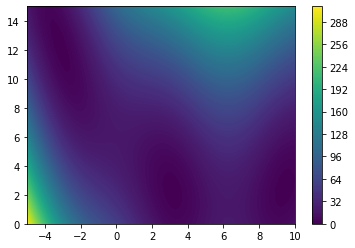

In [3]:
utilities.plot2d_func(target.eval, target.ranges)

## Parametric model

In [4]:
class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        
        self.alpha = PyroSample(dist.Uniform(0, 20))
        self.beta = PyroSample(dist.Uniform(0, 20))
        self.gamma = PyroSample(dist.Uniform(0, 20))
        
    def forward(self, X):

        x1 = X[...,0]
        x2 = X[...,1]
        return self.alpha*torch.cos(x1) + self.beta*torch.pow(x1, 4) + torch.pow(x2, 2) + self.gamma

## Parameters

In [5]:
num_simulations = 10

bo_steps = 20 + 1

opti_num_steps = 100
opti_params = {"lr": 0.1}
optimizer = pyro.optim.Adam(opti_params)
loss = Trace_ELBO()

return_site = "EI"

# Acquisition function optimizer
acqf_optimizer = torch.optim.Adam
acqf_opti_num_steps = 100
acqf_opti_lr = 0.5

num_candidates = 10

# Sampling
num_samples = 5

# Initial random points
N_train_points = 1

## SBO simulations

In [6]:
results = None

for sim_i in range(num_simulations):
    
    try:
        print("Sim {} start".format(sim_i))
        
        X_train = torch.rand(N_train_points, 2)*15 + torch.FloatTensor([target.ranges[0][0], target.ranges[1][0]])

        y_train = target.eval(X_train)

        pyro.clear_param_store()

        # GP kernel
        kernel = gp.kernels.Matern52(
            input_dim = X_train.shape[1], lengthscale = 100*torch.ones(X_train.shape[1]))

        # Semi paramteric GP model
        model = sbo.SemiParametricModel(X_train, y_train, ParametricMeanFn(), kernel)

        # Defining GP's parameters
        model.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 100).expand([X_train.shape[1]]).to_event())
        model.gp.kernel.variance = PyroSample(dist.Uniform(0, 50))
        model.gp.noise = PyroSample(dist.Uniform(0, 1))

        guide = None
        xmins = np.zeros([bo_steps, 2], np.float32)

        for i in range(bo_steps):

            guide, predict, losses = sbo.step(model, guide, optimizer, loss, target, acqf_optimizer, 
                                              opti_num_steps=opti_num_steps, acqf_opti_num_steps=acqf_opti_num_steps,
                                              acqf_opti_lr=acqf_opti_lr, num_samples=num_samples, 
                                              num_candidates=num_candidates,
                                              return_site=return_site)

        if sim_i == 0:
            results = np.hstack((model.X.numpy(), model.y.unsqueeze(dim=1).numpy()))
        else:
            results = np.dstack((results, 
                                 np.hstack((model.X.numpy(), model.y.unsqueeze(dim=1).numpy()))))
    except:
        sim_i -= 1

Sim 0 start
Sim 1 start
Sim 2 start
Sim 3 start
Sim 4 start
Sim 5 start
Sim 6 start
Sim 7 start
Sim 8 start
Sim 9 start


Pickling the results

In [7]:
output = open('sbo_10_results.pkl', 'wb')
pickle.dump(results, output)
output.close()